# Pychenette n° 1 : Visualiser les noms de couleur dans les tweets

**Pychenette** est une série de notebooks, en français, courts et amusants avec Python.

**Auteur** : Francis Wolinski

Pour tout commentaire : pychenette[at]yotta-conseil.fr

#### L'idée de ce notebook

A partir d'un corpus de textes (tweets en anglais), on extrait les vecteurs Word2Vec correspondants aux noms de couleur et on les représente en 2D avec un disque coloré dont le rayon correspond au nombre de tweets mentionnant la couleur. L'idée est de visualiser la proximité sémantique des noms de couleur.

Données utilisées :
- Pour les tweets, on utilise le corpus Sentiment140 qui comprend 1,6 M de tweets : https://www.kaggle.com/datasets/ferno2/training1600000processednoemoticoncsv
- Pour les couleurs, on utilise le fichier `rgb.txt` issu l'étude XKCD sur les noms de couleurs qui en dénombre 954 : https://xkcd.com/color/rgb/

<a href="notebooks/Pychenette-1-Visualiser-les-noms-de-couleur-dans-les-tweets.ipynb">Accès au notebook</a>

<a href="https://pychenette.yotta-conseil.fr/"><i class="fa fa-home"></i></a>

In [1]:
# imports
from os.path import exists
from collections import Counter, namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

### Chargement des tweets

On part du fichier CSV des tweets et on utilise uniquement la colonne "tweet". Il y a 1,6 millions de tweets.

In [2]:
# load tweets into a dataframe
df = (pd.read_csv("training.1600000.processed.noemoticon.csv",
                 encoding="latin-1",
                 usecols=[ "tweet"])
     )

df.shape

(1600000, 1)

### Traitement avec gensim

On préprocesse les tweets, puis on construit un modèle Word2Vec en prenant une fenêtre de 10  mots et des vecteurs de longueur 200.

In [3]:
tweets = df["tweet"].apply(lambda x: gensim.utils.simple_preprocess(x))

In [4]:
if not exists("sentiment140.bin"):
    model = gensim.models.Word2Vec(tweets,
                                   window=10,
                                   vector_size=200)
    model.save("sentiment140.bin")
else:
    model = gensim.models.Word2Vec.load("sentiment140.bin")

### Obtention des noms de couleurs et de leur représentation RVB

On exploite le fichier `rgb.txt` qui fournit les noms de couleur et les codes RVB. On élimine les noms de couleur qui contiennent un espace comme "cloudy blue" ou un slash comme "green/yellow". Il reste 250 noms de couleur.

In [5]:
rgb = pd.read_csv("rgb.txt",
                   sep="\s+#",
                   skiprows=1,
                   engine="python",
                   header=None,
                   names=["color", "rgb"])

rgb = (rgb
      .loc[lambda df: ~df["color"].str.contains(r"[\s/]", regex=True)]
      .assign(rgb=lambda df: "#" + df["rgb"])
      .set_index("color")["rgb"]
      )

len(rgb)

250

### Calcul de la fréquence des noms de couleur mentionnés

On calcule le nombre de tweets dans lequel chaque nom de couleur est mentionné. Il reste 225 noms de couleur.

In [6]:
colors = set(rgb.index)
frequency = Counter()

for tweet in tweets:
    frequency.update(set(tweet).intersection(colors))
    
len(frequency)

225

### Constitution d'un jeu de données complet

On constitue un jeu de données complet sous la forme d'une liste de namedtuples `Color` comprenant pour chaque couleur mentionnée : son nom, sa fréquence, son code RVB et son vecteur. Il reste 193 noms de couleur.

In [7]:
Color = namedtuple("Color", "color freq rgb vect")

colors_data = [Color(color,
                     frequency[color],
                     rgb[color],
                     model.wv.get_vector(color, norm=True) if color in model.wv.key_to_index else None)
               for color in colors
               if color in model.wv.key_to_index]

colors_data.sort(key=lambda x: x.freq, reverse=True)

len(colors_data)

193

### Les 10 noms de couleur les plus mentionnés dans les tweets

In [8]:
print(*[color[:3] for color in colors_data[:10]], sep="\n")

('shit', 7174, '#7f5f00')
('coffee', 6519, '#a6814c')
('red', 3964, '#e50000')
('ice', 3899, '#d6fffa')
('tea', 3336, '#65ab7c')
('cream', 3290, '#ffffc2')
('chocolate', 2995, '#3d1c02')
('black', 2935, '#000000')
('green', 2682, '#15b01a')
('white', 2476, '#ffffff')


### Application de l'algorithme t-SNE

L'algorithme t-SNE permet d'opérer une réduction des dimensions des vecteurs en conservant leur proximité géométrique. On visualise ensuite chaque couleur sous la forme d'un disque coloré dont le rayon correspond au nombre de tweets mentionnant la couleur.

Le graphique produit quelques regroupements intéressants :

- les noms de couleur correspondant à des boissons ou de la nouriture : tea, coffee, chocolate, apple, orange... (une bonne trentaine au total)
- les noms de couleur de base : black, white, red, blue, green...
- les noms de couleur correspondant à des zones géographiques : earth, ocean, sea, forest, desert...
- etc.

In [9]:
vectors = np.array([colors.vect for colors in colors_data])
tsne = TSNE(n_components=2, perplexity=8.0, random_state=42)
result = tsne.fit_transform(vectors)

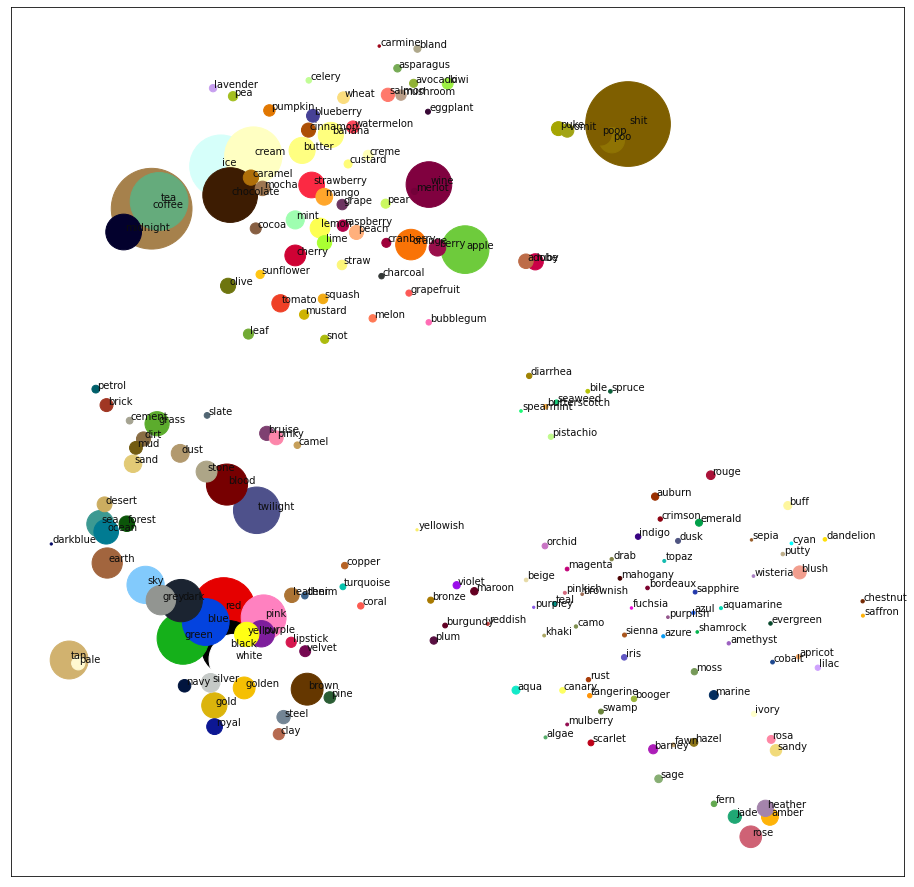

In [10]:
fig, ax = plt.subplots(figsize=(16,16))

ax.set_xticks([])
ax.set_yticks([])

ax.scatter(result[:,0],
           result[:,1],
           c=[color.rgb for color in colors_data],
           s=[color.freq for color in colors_data]);

for color, x, y in zip([t.color for t in colors_data], result[:,0], result[:,1]):
    ax.text(x+0.1, y+0.1, color, color="0.05")